Данный блокнот является лишь ***кривым*** и ***вольным*** переводом с китайского на русский, возможно, не отражающим полной сути написанного, *все права принадлежат его оригинальному владельцу* (даже с учетом, что это слитая нейросеть)

[Оригинал](https://colab.research.google.com/github/thd2020/novelai-leaks/blob/main/%E2%80%9CNovelAILeaks_API_Backend_(4chan_Ver_)%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb?pli=1&authuser=1) < - -

***Краткий гайд***

1. Подключиться к удаленной среде (подключается автоматически при запуске любой ячейки)

2. Запустить *поочередно* ячейки 0, 1, 2, дождаться выполнения

3. На свой выбор запустить ячейки 3 либо 4, дождаться запуска сервера

4. Перейти на сгенерированную ссылку

In [ ]:
#@title ### 0. Проверка ГПУ

!nvidia-smi

In [ ]:
#@title ### 1. Загрузка серверной части и модели NovelAI 
#@markdown Ожидаем появления в консоли "Done." и завершения работы ячейки

%cd /content/
!apt install -y -qq aria2
!aria2c --summary-interval=5 -x 3 --allow-overwrite=true -Z \
  https://pub-2fdef7a2969f43289c42ac5ae3412fd4.r2.dev/naifu.tar \
  https://pub-2fdef7a2969f43289c42ac5ae3412fd4.r2.dev/animefull-latest.tar 
  
!echo "Decompressing..."
!tar xf naifu.tar && rm naifu.tar
!echo "Done."

In [ ]:
#@title ### 2. Установка зависимостей
#@markdown Терпеливо ожидаем завершения, после остановки работы ячейки ничего не трогаем
%cd /content/naifu
!pip install virtualenv && bash ./setup.sh
!curl -Ls https://github.com/ekzhang/bore/releases/download/v0.4.0/bore-v0.4.0-x86_64-unknown-linux-musl.tar.gz | tar zx -C /usr/bin
!curl -Lo /usr/bin/cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 && chmod +x /usr/bin/cloudflared

In [ ]:
#@title ### 3. Запуск модели (4G)
#@markdown На этот раз ждать завершения работы ячейки не нужно, так как без неё не будет работать сайт
#@markdown - Ожидаем появления в консоли текста "Application startup complete."
#@markdown - Открываем ссылку из консоли выше, обозначенную рамкой (пример чуть ниже)
#@markdown - Ссылка генерируется рандомно, из случайных слов (так же если браузер жалуется на "фальшивость" сайта, пропускаем)
%cd /content/naifu
!sed -i 's/# export SAVE_FILES="1"/export SAVE_FILES="1"/g' run.sh
!bash run.sh & cloudflared tunnel --url localhost:6969 

Пример ссылки: 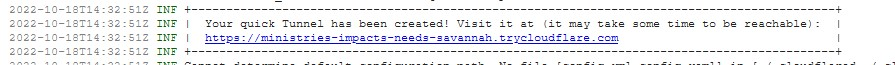

In [ ]:
#@title ### 4. （Опционально) Запуск модели `animefull-latest`, 7G
#@markdown По умолчанию NovelAi использует 4G модель, однако, если же вам понадобилась 7G модель (*пусть особой разницы в них и нет*) - то пропускайте 3 ячейку и запускайте эту
#@markdown * Делаем то же самое, что и в ячейке 3

%cd /content/
!tar xf animefull-latest.tar -C /content/naifu/models && rm animefull-latest.tar
!sed -i 's/map_location="cpu"/map_location="cuda"/g' /content/naifu/hydra_node/models.py

%cd /content/naifu
%env DTYPE=float16
%env CLIP_CONTEXTS=3
%env AMP=1
%env MODEL=stable-diffusion
%env DEV=True
%env MODEL_PATH=models/animefull-latest
%env ENABLE_EMA=1
%env VAE_PATH=models/animevae.pt
%env PENULTIMATE=1
%env PYTHONDONTWRITEBYTECODE=1
%env SAVE_FILES=1

!./venv/bin/python -m uvicorn --host 0.0.0.0 --port=6969 main:app & bore local 6969 --to bore.pub & cloudflared tunnel --url localhost:6969 

***Небольшие наблюдения***

1. при генерировании **7 и больше** изображений нейросеть выдает ошибку генерации, и не выдает результаты


2. Токены это количество того, сколько деталей присутствует на нынешнем запросе, а не общее количество того, сколько генераций вы сделали

3. Все сгенерированные изображения находятся по пути *`/content/naifu/images/`* (создается после первой генерации)

